## Look Elsewhere Effect in 2-d

Kyle Cranmer, Nov 19, 2015

Based on
*Estimating the significance of a signal in a multi-dimensional search* by  Ofer Vitells and Eilam Gross http://arxiv.org/pdf/1105.4355v1.pdf

This is for the special case of a likelihood function of the form 
$L(\mu, \nu_1, \nu_2)$ where $\mu$ is a single parameter of interest and
$\nu_1,\nu_2$ are two nuisance parameters that are not identified under the null.
For example, $\mu$ is the signal strength of a new particle and $\nu_1,\nu_2$ are the
unknown mass and width of the new particle. Under the null hypothesis, those parameters 
don't mean anything... aka they "are not identified under the null" in the statistics jargon.
This introduces a 2-d look elsewhere effect.

The LEE correction in this case is based on 

\begin{equation}
E[ \phi(A_u) ] = P(\chi^2_1 > u) + e^{-u/2} (N_1 + \sqrt{u} N_2) \,
\end{equation}
where 
   * $A_u$ is the 'excursion set above level $u$ (eg. the set of parameter points in $(\nu_1,\nu_2)$ that have a -2 log-likelihood ratio greater than $u$ )
   * $\phi(A_u)$ is the Euler characteristic of the excursion set
   * $E[ \phi(A_u) ]$ is the expectation of the Euler characteristic of those excursion sets under the null
   * $P(\chi^2_1 > u)$ is the standard chi-square probability 
   * and $N_1$ and $N_2$ are two coefficients that characterize the chi-square random field.
   
### structure of the notebook

The notebook is broken into two parts.
  * create a ROOT file with some toy histograms for this example
  * read in those toy histograms used to estimate $N_1$ and $N_2$
  * calculate the global p-value (eg. correct for the look-elsewhere effect)

In [1]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [2]:
from lee2d import *

## Create some test histograms

In [3]:
from create_test_histograms import *
create_test_histograms()

Welcome to ROOTaaS 6.05/03


In [4]:
#check to make sure test_hists.root exists
!ls *root

test_hists.root


## Calculate global p-value based on maximum local significance and several toy likelihood scans

In [5]:
# Specify the necessary info
max_local_significance = 4. 
# choose u1, u2 thresholds for doing the scan.
# these are arbitrary 
# if there are enough toys the choice shouldn't matter, but 
# we may want to do some tests with other choices
this_u1, this_u2 = 0.1, 0.9

In [6]:
# Specify the root file with the histograms and their names
root_file_name = 'test_hists.root'
num_toy_scans = 25
names_of_toy_likleihood_scans = [('scan_toy_%d' %(i)) for i in range(11,num_toy_scans)]

In [7]:
def convert_hist_to_numpy(hist):
    """a little helper script"""
    temp = np.zeros((hist.GetNbinsX(), hist.GetNbinsY()))
    for i in range(temp.shape[0]):
        for j in range(temp.shape[1]):
            temp[i,j] = hist.GetBinContent(i+1, j+1)
    return temp

In [8]:
# Read in histograms, convert them to numpy arrays
inFile = ROOT.TFile(root_file_name, 'READ')
likelihoodScans = []
for histName in names_of_toy_likleihood_scans:
    inHist = inFile.Get(histName)
    temp = convert_hist_to_numpy(inHist)
    likelihoodScans.append(temp)   

In [9]:
def get_euler_characteristics(listOfScans, u1=0.1, u2=0.9):
    """
    loop through the likleihood scans and calculate expectation
    of Euler characteristic for excursion sets above levels u1, u2
    """
    plt.figure(figsize=(9,len(listOfScans)*3))
    phis = np.zeros((len(listOfScans),2))
    for scan_no, scan in enumerate(listOfScans):
        plt.subplot(len(listOfScans),3,3*scan_no+1)
        aspect = 1.*scan.shape[0]/scan.shape[1]
        plt.imshow(scan.T, cmap='gray', aspect=aspect)

        #get excursion sets above those two levels
        exc1 = (scan>u1) + 0. #add 0. to convert from bool to double
        exc2 = (scan>u2) + 0.
        print '\nu1,u2 = ', u1, u2
                    
        plt.subplot(len(listOfScans),3,3*scan_no+2)
        plt.imshow(exc1.T, cmap='gray', aspect=aspect)
        plt.subplot(len(listOfScans),3,3*scan_no+3)
        plt.imshow(exc2.T, cmap='gray', aspect=aspect)
        
        phi1 = calculate_euler_characteristic(exc1)
        phi2 = calculate_euler_characteristic(exc2)
        print 'phi1, phi2 = ', phi1, phi2
        phis[scan_no] = [phi1, phi2]

    plt.savefig('islands.png')
    print 'Exp phi_0=%f, phi_2=%f' %(mean(phis[:,0]), mean(phis[:,1]))
    return mean(phis[:,0]), mean(phis[:,1])
                    


u1,u2 =  0.1 0.9
1138-2107+973=4
405-705+304=4
phi1, phi2 =  4 4

u1,u2 =  0.1 0.9
1747-3253+1512=6
895-1609+720=6
phi1, phi2 =  6 6

u1,u2 =  0.1 0.9
1306-2418+1117=5
663-1193+535=5
phi1, phi2 =  5 5

u1,u2 =  0.1 0.9
1174-2180+1010=4
430-768+342=4
phi1, phi2 =  4 4

u1,u2 =  0.1 0.9
1386-2578+1196=4
616-1101+490=5
phi1, phi2 =  4 5

u1,u2 =  0.1 0.9
1502-2795+1298=5
700-1257+562=5
phi1, phi2 =  5 5

u1,u2 =  0.1 0.9
1007-1870+867=4
390-701+314=3
phi1, phi2 =  4 3

u1,u2 =  0.1 0.9
1046-1942+900=4
298-523+229=4
phi1, phi2 =  4 4

u1,u2 =  0.1 0.9
1194-2210+1021=5
452-800+352=4
phi1, phi2 =  5 4

u1,u2 =  0.1 0.9
828-1502+680=6
300-531+234=3
phi1, phi2 =  6 3

u1,u2 =  0.1 0.9
1268-2339+1077=6
538-937+405=6
phi1, phi2 =  6 6

u1,u2 =  0.1 0.9
1554-2918+1368=4
759-1383+628=4
phi1, phi2 =  4 4

u1,u2 =  0.1 0.9
1419-2683+1266=2
619-1106+491=4
phi1, phi2 =  2 4

u1,u2 =  0.1 0.9
1558-2881+1328=5
455-788+340=7
phi1, phi2 =  5 7
Exp phi_0=4.571429, phi_2=4.571429


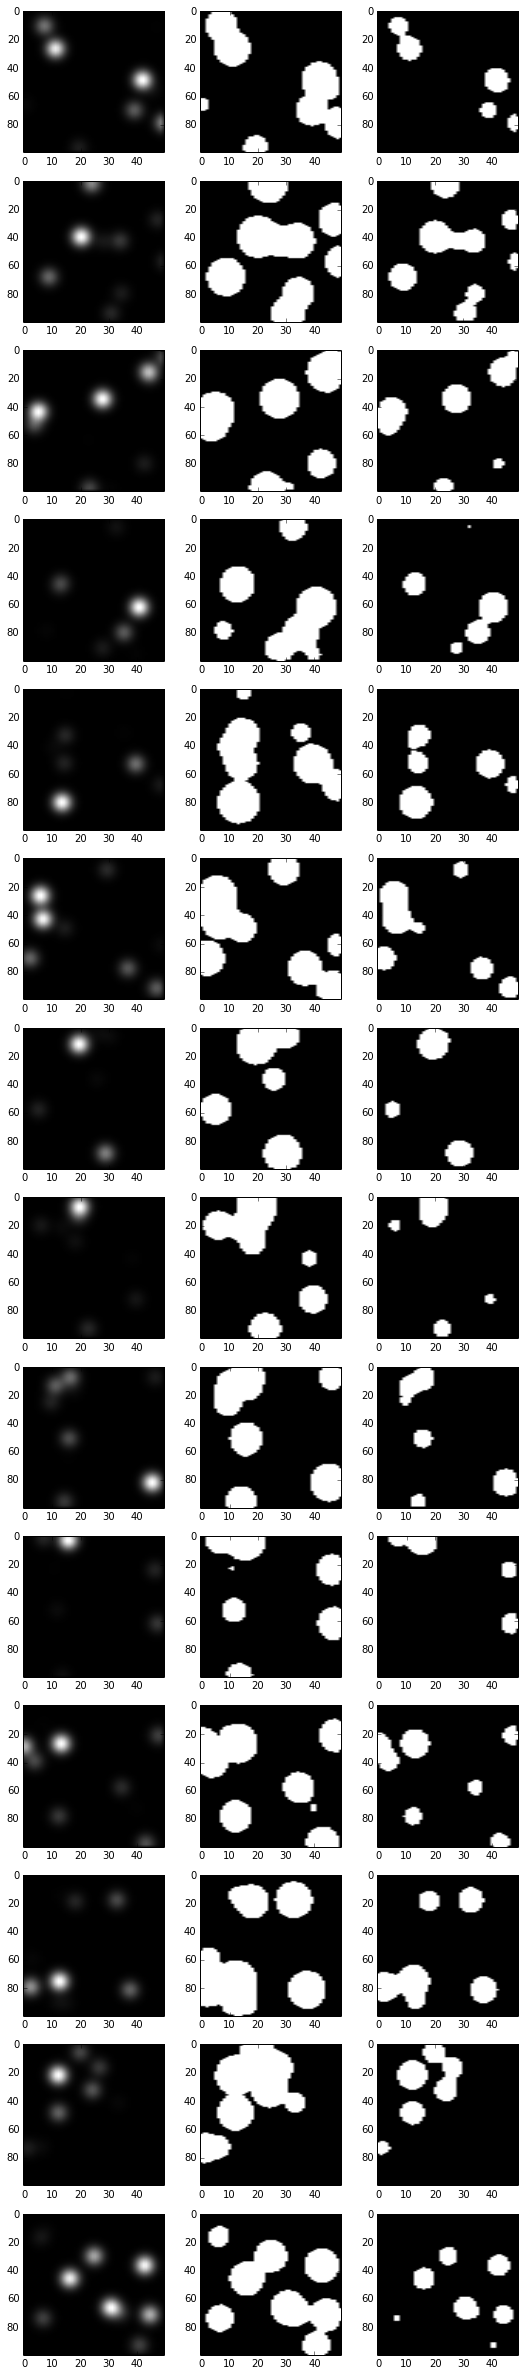

In [10]:
expphi1, expphi2 = get_euler_characteristics(likelihoodScans, u1=this_u1, u2=this_u2)

In [11]:
global_p_value = do_LEE_correction(max_local_significance, this_u1, this_u2, expphi1, expphi2)

 n1, n2 = 3.74802274901 2.51999896977
 local p_value = 0.000032,  local significance = 4.000000
global p_value = 0.004575, global significance = 2.606365
